# Denoising Diffusion Probabilistic Models with miniai

In [1]:
# import torch
# import torch.nn as nn

# from denoising_diffusion_pytorch.simple_diffusion import UViT

# model = UViT(256,
#              ff_mult=1,
#              vit_depth=4,
#              channels=4, 
#              patch_size=4,
#              final_img_itransform=nn.Conv2d(4,1,1))

# sum([torch.numel(p) for p in model.parameters()])

# x, t = torch.rand(2,4,128,128), torch.tensor([1,2])

# y = model(x,t)
# y.shape

## Imports

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial
from types import SimpleNamespace

from fastcore.foundation import L
from fastprogress import progress_bar
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [3]:
set_seed(42)

In [4]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [5]:
config = SimpleNamespace(    
    epochs = 30,
    model_name="ddpm_clouds",
    noise_steps=1000,
    seed = 42,
    batch_size = 8,
    img_size = 512,
    device = "cuda",
    use_wandb = True,
    num_workers=8,
    num_frames=3,
    compile=True,
    lr = 5e-4)

In [6]:
def ls(path): 
    return sorted(list(path.iterdir()))

In [7]:
import torchvision.transforms as T

class CloudDataset:
    
    def __init__(self, files, num_frames=4, scale=True, size=64):
        
        self.tfms = T.Compose([T.Resize((size, int(size*1.7))), 
                               T.RandomCrop(size),
                               T.RandomHorizontalFlip(),])
        
        data = []
        for file in progress_bar(files, leave=False):
            one_day = np.load(file)
            if scale:
                one_day = 0.5 - self._scale(one_day)
        
            wds = np.lib.stride_tricks.sliding_window_view(
                one_day.squeeze(), 
                num_frames, 
                axis=0).transpose((0,3,1,2))
            data.append(wds)
        self.data = np.concatenate(data, axis=0)
            
    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)
    
    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))
    
    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)

In [8]:
import wandb
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact('capecape/gtc/np_dataset:v1', type='dataset')
    artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact np_dataset:v1, 7633.24MB. 60 files... 
wandb:   60 of 60 files downloaded.  
Done. 0:0:0.0


In [9]:
# files = [f for f in ls(Path(artifact_dir)) if f.name.startswith("IR")]
files = ls(Path(artifact_dir))
files 

[Path('artifacts/np_dataset:v1/B07_2022_06_01.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_02.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_03.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_04.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_05.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_06.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_07.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_08.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_09.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_10.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_11.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_12.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_13.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_14.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_15.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_16.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_17.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_18.npy'),
 Path('artifacts/np_dataset:v1/B07_2022_06_19.

In [10]:
train_ds = CloudDataset(files[0:-3], size=config.img_size)
valid_ds = CloudDataset(files[-3:], size=config.img_size)

In [11]:
idxs = torch.randperm(len(valid_ds))

In [12]:
valid_ds.data = valid_ds.data[idxs]

In [13]:
train_dl = DataLoader(train_ds, config.batch_size, shuffle=True, num_workers=config.num_workers)
valid_dl = DataLoader(valid_ds, config.batch_size, num_workers=config.num_workers)

In [14]:
dls = DataLoaders(train_dl, valid_dl)

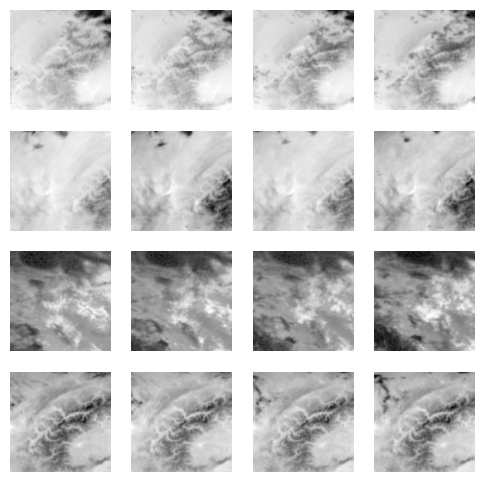

In [15]:
dt = dls.train
xb = next(iter(dt))
xb.shape

show_images(xb[:4].reshape(-1, 1, config.img_size, config.img_size), imsize=1.5, nrows=4)

In [16]:
betamin,betamax,n_steps = 0.0001,0.02,config.noise_steps
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [17]:
def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

def logsnr_schedule_cosine(t, logsnr_min = -15, logsnr_max = 15):
    t_min = math.atan(math.exp(-0.5 * logsnr_max))
    t_max = math.atan(math.exp(-0.5 * logsnr_min))
    return -2 * log(torch.tan(t_min + t * (t_max - t_min)))

In [18]:
def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

In [19]:
def q_sample(x_start, times, noise):
    log_snr = logsnr_schedule_cosine(times)

    log_snr_padded = right_pad_dims_to(x_start, log_snr)
    alpha, sigma = torch.sqrt(log_snr_padded.sigmoid()), torch.sqrt((-log_snr_padded).sigmoid())
    x_noised =  x_start * alpha + noise * sigma

    return x_noised, log_snr

In [20]:
def noisify(frames, pred_objective="v"):
    past_frames = frames[:,:-1]
    last_frame  = frames[:,-1:]
    device = frames.device
    
    noise =  torch.randn_like(last_frame)
    times = torch.zeros((last_frame.shape[0],), device = device).float().uniform_(0, 1)
    x, log_snr = q_sample(last_frame, times, noise)
    
    if pred_objective == 'v':
        padded_log_snr = right_pad_dims_to(x, log_snr)
        alpha, sigma = padded_log_snr.sigmoid().sqrt(), (-padded_log_snr).sigmoid().sqrt()
        target = alpha * noise - sigma * last_frame

    elif pred_objective == 'eps':
        target = noise
        
    return torch.cat([past_frames, x], dim=1), log_snr, target

In [21]:
xt, t, ε = noisify(xb[:4])
t

tensor([ 2.2328,  0.3617,  1.0596, -5.2748])

In [22]:
xt.shape

torch.Size([4, 4, 512, 512])

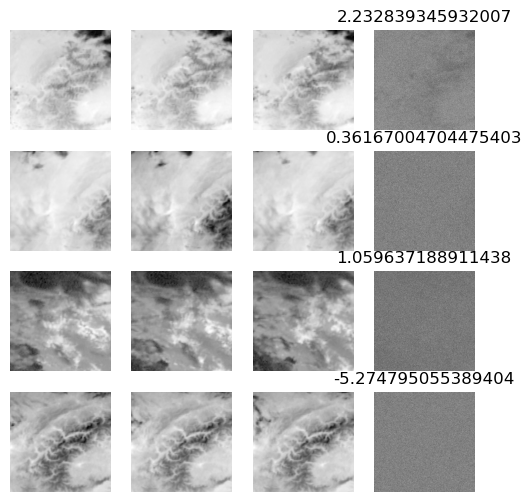

In [23]:
titles = fc.map_ex(t, '{}')
titles = fc.concat(zip([[None,None,None]]*len(titles), titles)) 
show_images(xt.reshape(-1, 1, config.img_size, config.img_size), imsize=1.5, titles=titles, nrows=4)

## Training

In [24]:
def collate_ddpm(b): return noisify(default_collate(b))

In [25]:
def dl_ddpm(ds, shuffle=False): return DataLoader(ds, batch_size=config.batch_size, collate_fn=collate_ddpm, shuffle=shuffle, num_workers=config.num_workers)

In [26]:
dls = DataLoaders(dl_ddpm(train_ds, shuffle=True), dl_ddpm(valid_ds))

In [27]:
def sample(model, xt): pass

## Accelerate

`pip install accelerate` before running this section.

In [28]:
from accelerate import Accelerator

In [29]:
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def after_fit(self, learn):
        learn.model = self.acc.unwrap_model(learn.model)
    
    def backward(self, learn): self.acc.backward(learn.loss)

In [30]:
import wandb
class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): self.model_name = model_name
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
        if hasattr(learn, 'metrics'): 
            self._log_copy = learn.metrics._log
            learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        self._log_copy(d)
        wandb.log(d)
    
    def after_batch(self, learn):
        if learn.training:
            wandb.log({"train_loss":learn.loss.item(),
                       "lr":learn.schedo.get_last_lr()[0]})
            
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [31]:
def to_wandb_image(img):
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(model, xt):
    samples = sample(model, xt)
    frames = torch.cat([xt[:, :-1,...].to(samples[-1].device), samples[-1]], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

In [32]:
class LogPreds(Callback):
    "Log samples to W&B"
    order = 99
    def __init__(self, n_preds=10, log_every=1): 
        self.n_preds=n_preds
        self.log_every = log_every
    
    def before_fit(self, learn):
        dt = learn.dls.valid
        xt, t, ε = next(iter(dt))
        self.xt = xt[:self.n_preds]
    
    def after_epoch(self, learn):
        if not learn.training and ((learn.epoch+1) % self.log_every == 0):
            log_images(learn.model, self.xt)

In [33]:
# class DDPMCB2(Callback):
#     def after_predict(self, learn): learn.preds = learn.preds.sample

In [34]:
tmax = config.epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=config.lr, total_steps=tmax)
opt_func = partial(optim.Adam, eps=1e-5)

In [35]:
from denoising_diffusion_pytorch.simple_diffusion import UViT
model = UViT(512,
             ff_mult=2,
             vit_depth=4,
             channels=4, 
             patch_size=4,
             final_img_itransform=nn.Conv2d(4,1,1))

In [36]:
# init_ddpm(model)

In [37]:
cbs = [ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=config.lr, cbs=cbs, opt_func=opt_func)

In [38]:
{cb.__class__.__name__:cb.order for cb in learn.cbs}

{'ProgressCB': 1, 'MetricsCB': 0, 'BatchSchedCB': 0, 'AccelerateCB': 10}

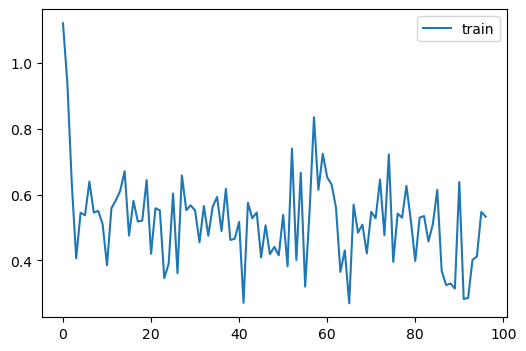

In [ ]:
run = wandb.init(project="ddpm_clouds", config=config, tags=["uvit"])

learn.fit(config.epochs, cbs=[WandbCB("ddpm_uvit")])

In [ ]:
wandb.finish()

In [ ]:
!sudo poweroff